<a href="https://colab.research.google.com/github/liadmagen/Modeling_course/blob/main/exercises_notebooks/01_wine_tasting_decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wine Tasting

In this exercise you will create and train a Decision-Tree classifier model, and compare it to two differet regression models. You will use Python for this and get to know the popular scientific package - [Sci-Kit-Learn](https://scikit-learn.org/stable/). 

## Context

This dataset is related to red variants of the Portuguese "Vinho Verde" wine and was taken from here: https://archive.ics.uci.edu/ml/datasets/wine+quality. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

## The Data

For more information, read [Cortez et al., 2009].

Input variables (based on physicochemical tests):
1. fixed acidity
2. volatile acidity
3. citric acid
4. residual sugar
5. chlorides
6. free sulfur dioxide
7. total sulfur dioxide
8. density
9. pH
10. sulphates
11. alcohol

Output variable (based on sensory data) - the *label*:
12. quality (score between 0 and 10)

## Our task today:

Use machine learning to determine which physiochemical properties make a wine 'good'!

## Acknowledgements

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.


# Decision Tree

## Introduction
We will start with an analysis of our data. We will plot the histograms and try to think which features would be the best to describe the wine taste.

Decision Trees use yes/no (binary) questions to query the feautres to make a decision.

Please read more about them in the SciKit-learn python package which we're using here to creat them: https://scikit-learn.org/stable/modules/tree.html
 

## Data preparation and examination

In [1]:
# Import the needed packages
import graphviz

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import seaborn as sns

%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [2]:
# Load the data:
df = pd.read_csv('https://raw.githubusercontent.com/liadmagen/Modeling_course/main/data/winequality-red.csv')

We begin (ALWAYS) with looking at our data.

In [3]:
# The data itself
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [4]:
# Statistics about the data - the percentiles can give us already a good indication about the features
# Can you  guess at this stage which of these features would be the most prominant in determing the quality (the taste)?
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


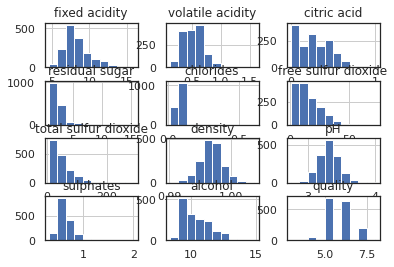

In [5]:
# And plotting histograms
hists = df.hist()

Before we train our Decision Tree, we want to do several thing:

1. We want to leave aside some of the values so we can have a good test for the model, so we can determine how well it performed. 
  
  Remind yourself that when a teacher creates an exam, they want to see that the students have actually understood the material, and not learned it by heart.

  Therefore, we need to put aside some wines to test the Decision Tree model on.

  [Scikit-Learn](https://scikit-learn.org/stable/index.html) has a great method for that: [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), which we are going to use here.
2. The quality is a number between 3 to 8 (look at the min/max in the statistics section), where most of the values are around 5 and 6. We can divide the quality into two classes, by answering the question - is this wine very good? Then we will get two classes: **FALSE** (<=6.5), and **TRUE** (>6.5), representing the **OK** and **VERY GOOD** labels. This will make the task easier for the algorithm (less leaf-types, mean more options to create helpful features). 

3. Machine Learning models are a function that based on the data, it creates a function. The data that the Machine Learning needs is in the form of:  `f(X) --> y`. Where `X` is a set of `features` and `y` is the `label` for these features.

In [6]:
# 'quality' is our label - the column we would like to predict. 
features_df = df.drop('quality', axis=1)

label = df['quality'] > 6.5

X_train, X_test, y_train, y_test = train_test_split(features_df, 
                                                    label, 
                                                    test_size=0.33, 
                                                    random_state=42)


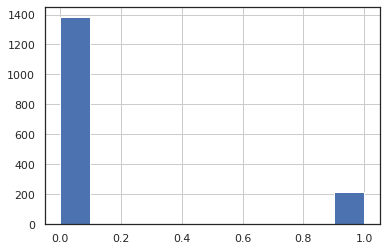

In [7]:
label.map(int).hist()

Before training our Decision Tree, let's look at the data again - this time according to our division of the good wines:

In [8]:
df[label].describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,217.0,8.847005,1.999977,4.90000,7.4000,8.70000,10.10000,15.6000
volatile acidity,217.0,0.405530,0.144963,0.12000,0.3000,0.37000,0.49000,0.9150
citric acid,217.0,0.376498,0.194438,0.00000,0.3000,0.40000,0.49000,0.7600
residual sugar,217.0,2.708756,1.363026,1.20000,2.0000,2.30000,2.70000,8.9000
chlorides,217.0,0.075912,0.028480,0.01200,0.0620,0.07300,0.08500,0.3580
free sulfur dioxide,217.0,13.981567,10.234615,3.00000,6.0000,11.00000,18.00000,54.0000
total sulfur dioxide,217.0,34.889401,32.572238,7.00000,17.0000,27.00000,43.00000,289.0000
density,217.0,0.996030,0.002201,0.99064,0.9947,0.99572,0.99735,1.0032
pH,217.0,3.288802,0.154478,2.88000,3.2000,3.27000,3.38000,3.7800
sulphates,217.0,0.743456,0.134038,0.39000,0.6500,0.74000,0.82000,1.3600


And the 'OK' wines:

In [9]:
df[~label].describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1382.0,8.236831,1.682726,4.60000,7.100000,7.8000,9.1000,15.90000
volatile acidity,1382.0,0.547022,0.176337,0.16000,0.420000,0.5400,0.6500,1.58000
citric acid,1382.0,0.254407,0.189665,0.00000,0.082500,0.2400,0.4000,1.00000
residual sugar,1382.0,2.512120,1.415778,0.90000,1.900000,2.2000,2.6000,15.50000
chlorides,1382.0,0.089281,0.049113,0.03400,0.071000,0.0800,0.0910,0.61100
free sulfur dioxide,1382.0,16.172214,10.467685,1.00000,8.000000,14.0000,22.0000,72.00000
total sulfur dioxide,1382.0,48.285818,32.585604,6.00000,23.000000,39.5000,65.0000,165.00000
density,1382.0,0.996859,0.001808,0.99007,0.995785,0.9968,0.9979,1.00369
pH,1382.0,3.314616,0.154135,2.74000,3.210000,3.3100,3.4100,4.01000
sulphates,1382.0,0.644754,0.170629,0.33000,0.540000,0.6000,0.7000,2.00000


Can you guestimate now which top 3 features would be meaningful in determing the wine quality?

## Training a Decision-Tree
Now we are ready to train our classifier!
Remember to never show your classifier the test-data! (Otherwise, it's cheating...)

In [15]:
# Instantiate the class instance:
decTree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3)

# Train it on our data
decTree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

Let's plot the first 3 layers of the tree, to examine which features contributes to the good wines:

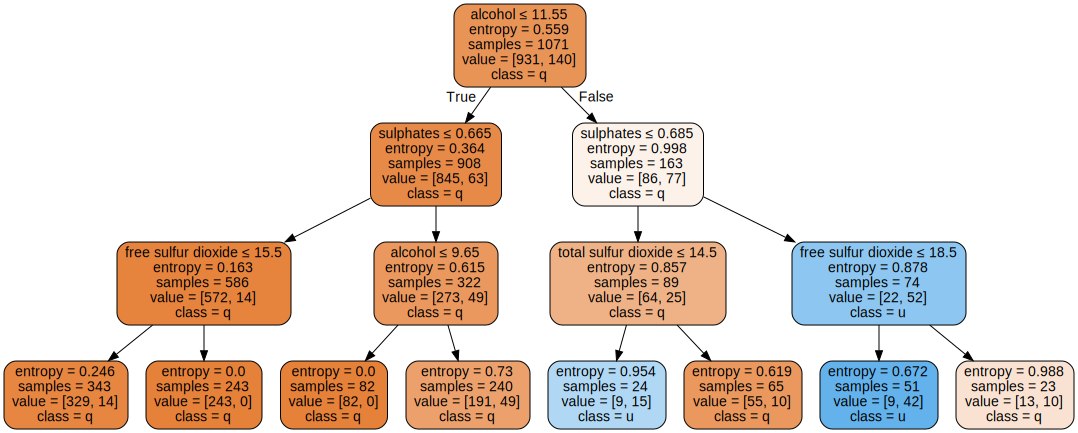

In [16]:
dot_data = tree.export_graphviz(decTree, out_file=None, 
                      feature_names=features_df.columns.to_list(),  
                      class_names='quality',
                      filled=True, rounded=True,
                      max_depth=3,
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

According to the Decision Tree model, `alcohol` is the strongest determinator. When there's more than `11.5%` alcohol in the wine, then the amount of suphates would determine its taste. Otherwise it would be the acidity.

Let's investigate the data based on this data.

In [12]:
# We add our True/False quality label to the dataset
df['label'] = label
# And count how many of them are True/False when the alcohol is less than 11.55 
df[df['alcohol'] <= 11.55]['label'].value_counts()

False    1242
True      107
Name: label, dtype: int64

In [13]:
# And when it is above it:
df[df['alcohol'] > 11.55]['label'].value_counts()

False    140
True     110
Name: label, dtype: int64

The `.value_counts()` method of `pandas` gives us the number of rows corresponds to the unique values in the column. You can read about it more here: https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html

How can you convert these counts into percentage of the total dataset size?

In [ ]:
### YOUR TURN ###
"""
Write code here to calculate the _percentage_ of good wine (True) compared to 
ok/bad wine (False) in the dataset, based on the alcohol column.

Try different values to divide the alcohol percentage with, such as:
   11, 11.55, 12 
how does these values affect the ratio?
"""



##################

'\nWrite code here to calculate the _percentage_ of good wine (True) compared to \nok/bad wine (False) in the dataset, based on the alcohol column.\n\nTry different values to divide the alcohol percentage with, such as:\n   11, 11.55, 12 \nhow does these values affect the ratio?\n'

## Assesing a model

In the preparation part, we have divided our data to train and test-set.
The test set helps us to see how well our model learned: does it only memorize the data, or can it infer and perform also n new, unseen data from the same distribution. This is referred to as the ability of a model **to generalize**.

There are [many methods](https://scikit-learn.org/stable/modules/classes.html?highlight=metrics#sklearn-metrics-metrics) to asses the model performance. These methods differ based on the task in hand: [classification](https://scikit-learn.org/stable/modules/classes.html?highlight=metrics#classification-metrics), [regression](https://scikit-learn.org/stable/modules/classes.html?highlight=metrics#regression-metrics), [clustering](https://scikit-learn.org/stable/modules/classes.html?highlight=metrics#clustering-metrics), etc.
But they all have one thing in common: They all measure some kind of a **distance**: for example, in our classification task, they measure the distance between our model's outputs, the *predicted values*, to our `y`, our pre-defined labels. Hence giving us an indicator about the quality of the model predictions.

We will use an assessment called [F-Score](https://deepai.org/machine-learning-glossary-and-terms/f-score).

If you are not familiar yet with precision, recall and f-score, please take a few minutes to read the explantion and examples here:
https://deepai.org/machine-learning-glossary-and-terms/f-score

If you are familiar with sensitivity and specificity:
* In what ways do precision and recall are similar to sensitivity and specificity?
* In what ways do they differ?

Compare your answers to this explanation: https://uberpython.wordpress.com/2012/01/01/precision-recall-sensitivity-and-specificity/

In [17]:
# sklearn.metrics library contains precision, recall, f-score, specificity and sensitivity
pred_test = decTree.predict(X_test)
print(classification_report(y_test, pred_test, target_names=['OK wine', 'Good wine']))

              precision    recall  f1-score   support

     OK wine       0.88      0.97      0.93       451
   Good wine       0.59      0.25      0.35        77

    accuracy                           0.87       528
   macro avg       0.74      0.61      0.64       528
weighted avg       0.84      0.87      0.84       528



Another metric for binary classification is [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curves.

Scikit-learn has [tools](https://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc) for [plotting](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html) those curves.

Calculate and plot here the ROC curve of our classifier results on the test-set:

* What is your Area Under Curve (AUC) score?
* We have previously set the quality level to 6.5. 
  What is the AUC score when defining the good wines score as above 7?

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

### YOUR TURN ###
# Write your code here








## Attribute Selection Measurement

As we showed in the class, in every calculation step, the [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn-tree-decisiontreeclassifier) must select the *most valuable feature*, the best attribute, to divide the data by. How does that work?

There are two main methods of measuring the feature contribution, which is referred to as the **purity** of the features.

[Purity](https://en.wikipedia.org/wiki/Information_gain_in_decision_trees) is the metric according to which a decision is made whether to split a node. Purity is the fraction (the percentage) of points corresponds to the majority label. A node is *100% impure* when a it is split evenly - 50/50, and it is *100% pure* when all of its data belongs to a single class.

Based on the purity measurement, the two methods are:

* **Information gain** (aka **Entropy**) - the measurement of changes in entropy after the segmentation of a dataset based on an attribute.
  
  *Information Gain* = *Entropy*(Total # of Samples) - [(Weighted Avg) * *Entropy*(each feature)]
  
  *Entropy* (sample) = $-P(yes) * log_2 P(yes)- P(no) log_2 P(no)$

  If a node is pure, that is, has all the points from the same class, then the entropy is zero. On the other hand, if the classes are all mixed up, and each appears with equal probability ofr any of the *k* features - $ P(C_i) = \frac{1}{k} $  then the entropy has the highest value.

* **Gini Index** (aka [Gini impurity](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity)) - a random-sampling based probability measurement of the purity of the data. It measures how often a randomly chosen row from the data table would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset.
  It's calculation formula is $1 - ∑_i^kP(C_i)^2$

  Or in words, one minus the squared sum of probabilities of each class. The lower the Gini index value, the better the split point is. If the node-division is pure, then the probability of the majority class is 1 and the probability of all other classes is 0, and thus, the Gini index is 0. On the other hand, when each class is equally represented, with probability $P(C_i) = 1$, then higher values of the Gini index indicate more disorder, and lower values indicate more order in terms of the class labels.


The DecisionTreeClassifier supports both options, and the default one (which we just used) is the 'Gini Index'.

### Exercise: 
Try replacing the Gini Index with entropy - check the documentation for how to perform this. 
> Observe: How does the entropy method affect on the results?

## Shallow Decision Tree

One of the attributes of the [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn-tree-decisiontreeclassifier) is limiting the depth of the tree, not allowing the tree to be deeper than **n** layers.

The previously trained Decision-Tree was unlimited in depth. 

Try limiting it to a depth of 3. 
> How does it affect the result?

In [ ]:
### YOUR TURN ###
# Create and train a DecisionTreeClassifier with entropy instead of the 
# default Gini index.
# Calculate the F-Score and the AUC with the test-set, and compare it to the 
# previous results













#################

To dive deeper in to Decision-Trees, a recommended reading is https://www.javatpoint.com/machine-learning-decision-tree-classification-algorithm

## Take-aways

* Decision Trees are simple to understand and to interpret (White-Box)
* They simulates human rational decision-making process
* They can handle both numerical (e.g. alcohol %) and categorical (e.g. colors) features
* They requires little to no data preparation
* They can perform well on both small and large datasets

# Regression

You have already learned about regression models. Let's rehearse them now using python and Scikit-Learn.

We will practice two simple regression models: [Linear Regression](https://scikit-learn.org/stable/modules/linear_model.html#generalized-linear-regression) and [Logistic Regression](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression).


First, let's import the packages we are going to use

In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression  
from sklearn.preprocessing import StandardScaler

--- 

We begin with Linear Regression - and attempt to fit a straight line to our data.


We begin, as before, by dividing our data and leaving some of it aside to test the model with.

This time, we will use the `quality` column as it is: a set of numerical values.
We will try to predict the quality score based on the features.

In [ ]:
# 'quality' is our label - the column we would like to predict. 
features_df = df.drop('quality', axis=1)

label = df['quality']

X_train, X_test, y_train, y_test = train_test_split(features_df, 
                                                    label, 
                                                    test_size=0.33, 
                                                    random_state=42)

In [ ]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression()

Let's see how well did our Linear Regressor do on our saved-aside test set:

In [ ]:
y_pred= regressor.predict(X_test)

print('predictions: ', y_pred[:5])
print('rounded predictions: ', list(map(round, y_pred))[:5])
print('true values: ', y_test.to_list()[:5])

predictions:  [5.34555675 5.1382492  5.48770853 5.42014113 5.53690683]
rounded predictions:  [5, 5, 5, 5, 6]
true values:  [6, 5, 6, 5, 6]


Let's plot the predictions.

The true values are the blue dots, and the red are our predictions.

You can switch between the commentted lines to compare the rounded points and the true value of the regressor classifier.

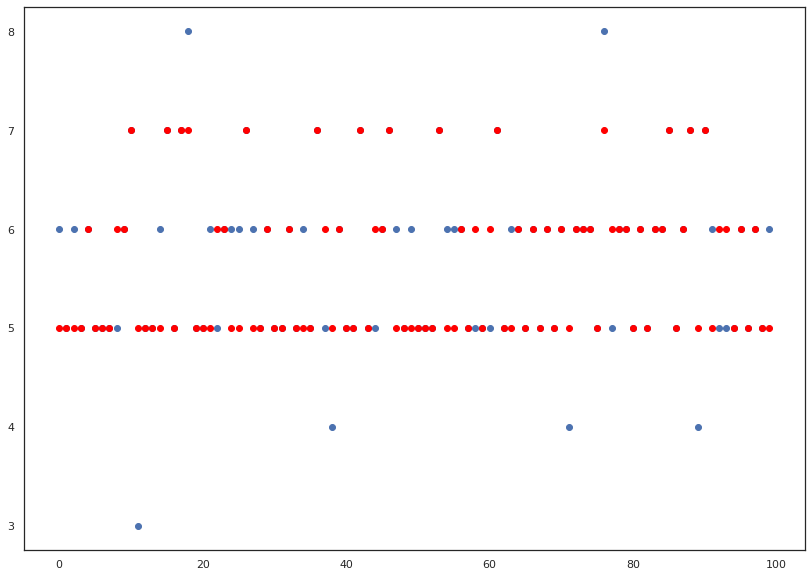

In [ ]:
# num_of_points = len(y_test)
num_of_points = 100

plt.scatter(range(num_of_points), y_test[:num_of_points])

# plot the rounded points:
plt.scatter(range(num_of_points), list(map(round, y_pred))[:num_of_points], color="red")

# plot the true regression values
# plt.scatter(range(num_of_points), y_pred[:num_of_points], color="red")

## Giving it a score

For classification, we used classification-related metrics, such as F-Score, Precision, Recall, RUC and AUC scores.

We can't use those for regression - we have no classes output.

Instead, we need so somehow calculate the **distance** between our predicted results to the real results.

In [ ]:
from sklearn.metrics import mean_absolute_error, explained_variance_score

print('mean absolute error: ', mean_absolute_error(y_test, y_pred))
print('explained variance score: ', explained_variance_score(y_test, y_pred))

mean absolute error:  0.4072606424405148
explained variance score:  0.6102893183518037


If we round our predictions, the result is slightly better (less error):

In [ ]:
print('mean absolute error: ', mean_absolute_error(y_test, list(map(round, y_pred))))
print('explained variance score: ', explained_variance_score(y_test, list(map(round, y_pred))))


mean absolute error:  0.32765151515151514
explained variance score:  0.47833693526808685


---

Now that we have a number, we can compare that result to a Logistic Regression.

Logistic Regression fits a non-straight line, so it can match better to the data. It requires some preparation, though: We need to normalize our data.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_df, 
                                                    label, 
                                                    test_size=0.33, 
                                                    random_state=42)

In [ ]:
st_x= StandardScaler()    
X_train= st_x.fit_transform(X_train)    
X_test= st_x.transform(X_test)

Let's take a look at our normalized data:

In [ ]:
pd.DataFrame(X_train, columns=df.columns[:len(df.columns) - 1])

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,2.400695,-1.031037,1.127426,0.037723,-0.184551,1.078264,0.674266,1.422247,-1.260963,0.527261,-0.014319,-0.387783
1,-0.939671,1.229204,-1.325022,-0.104411,-0.205698,0.105783,-0.447656,-0.694295,1.526228,-0.282257,2.243632,-0.387783
2,-0.998274,0.551132,-1.376115,1.245861,0.111497,3.412217,0.932005,-0.650879,-0.742416,-1.207421,-0.861050,-0.387783
3,1.580254,-1.313567,1.587260,-0.317611,-0.713209,-0.866697,-0.841845,0.662462,-0.029413,1.278957,0.079763,2.578759
4,0.056578,1.200951,-0.814096,-0.459745,0.048058,0.008535,0.492333,-0.151592,-0.807234,0.932021,-0.766969,-0.387783
...,...,...,...,...,...,...,...,...,...,...,...,...
1066,0.466799,0.381614,-1.376115,-0.459745,-0.628624,-1.061193,-1.114746,0.499652,-0.872053,-0.166612,-0.014319,-0.387783
1067,-0.060627,0.579385,-0.865188,-0.317611,-0.311429,0.883768,0.401366,-0.216716,-0.159050,0.527261,0.456088,-0.387783
1068,-0.646657,0.494626,-1.069559,0.108790,-0.226844,-0.088713,1.159422,0.369403,1.266955,-0.687016,-0.861050,-0.387783
1069,-0.236436,-1.878628,0.412128,-0.601879,-0.713209,-0.866697,-0.963134,-1.193582,0.035405,0.816375,1.396901,2.578759


In [ ]:
pd.DataFrame(X_train, columns=df.columns[:len(df.columns) - 1]).describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1071.0,-3.827211e-16,1.000467,-2.170333,-0.705260,-0.236436,0.525402,4.451797
volatile acidity,1071.0,1.498957e-16,1.000467,-2.330676,-0.748507,-0.070435,0.607638,4.506554
citric acid,1071.0,-2.038260e-16,1.000467,-1.376115,-0.916281,-0.047706,0.820870,3.733152
residual sugar,1071.0,4.295765e-16,1.000467,-1.170414,-0.459745,-0.246544,0.037723,9.205354
chlorides,1071.0,3.118161e-16,1.000467,-1.601355,-0.353722,-0.163405,0.048058,11.065288
free sulfur dioxide,1071.0,-5.742890e-17,1.000467,-1.450185,-0.866697,-0.185961,0.494776,5.065434
total sulfur dioxide,1071.0,4.125759e-17,1.000467,-1.236034,-0.750879,-0.265723,0.492333,7.345157
density,1071.0,4.908658e-14,1.000467,-3.641172,-0.588468,0.011219,0.570203,3.750442
pH,1071.0,8.691046e-16,1.000467,-3.724063,-0.612779,-0.029413,0.553952,4.507875
sulphates,1071.0,3.243593e-16,1.000467,-1.670003,-0.629193,-0.224434,0.411616,7.755104


Notice that the standard deviation is now the same over all the columns; The maximum `total sulfur dioxide` is now only `7.3`. In fact, all the values have been `squeezed` to fit a smaller range. 

If we use the `LogisticRegression` on our original values, we will receive computation errors. By squeezing the data into smaller range, we avoid those errors and are enable to fit a regressor.

We will see later that the same method is used for many other classifiers, including Deep Learning. This may also help to understand the easiness and non-complicated nature of the Decision Tree.

In [ ]:
classifier = LogisticRegression(random_state = 42)
  
classifier.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(random_state=42)

In [ ]:
y_pred= classifier.predict(X_test)  

In [ ]:
print('mean absolute error: ', mean_absolute_error(y_test, y_pred))
print('explained variance score: ', explained_variance_score(y_test, y_pred))

mean absolute error:  0.3125
explained variance score:  0.47690699425315386


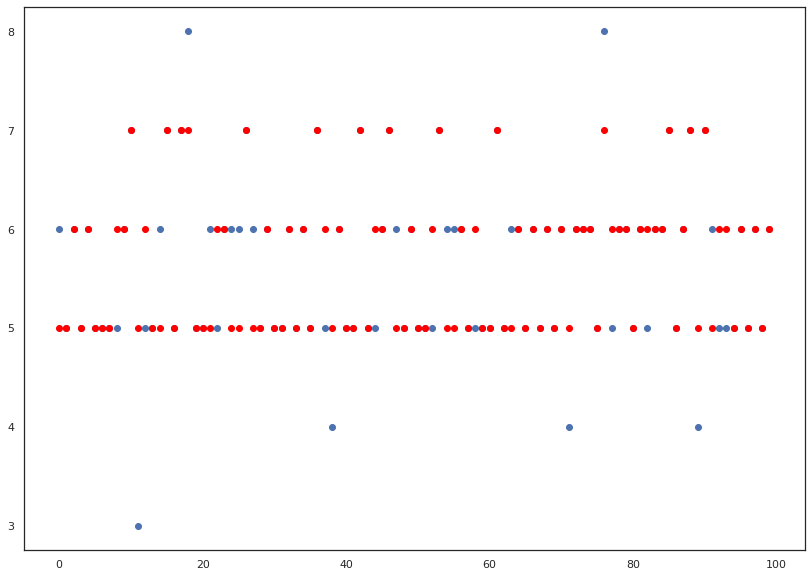

In [ ]:
# num_of_points = len(y_test)
num_of_points = 100

plt.scatter(range(num_of_points), y_test[:num_of_points])

# plot the rounded points:
# plt.scatter(range(num_of_points), list(map(round, y_pred))[:num_of_points], color="red")

# plot the regression values
plt.scatter(range(num_of_points), y_pred[:num_of_points], color="red")

The red points are hiding the blue points - meaning they were predicted correctly. The blue points are the missed one.

Overall, for our data, it seems that the Logistic Regression method performed only slightly better than the linear regression one after rounding our data points. 

Compared to the regression methods, the Decision-Tree had given us insights about the importance of the features in determining the taste quality score. Also, it did not require pre-processing techniques such as normalizing the data first.

---

## Computation Limitations
The Decision-Tree we have detected is good - but not optimal.
To find the optimal Decision-Tree is a NP-Complete problem in computer science. That is, it can not be solved in a reasonable time frame (As a function of the input size).


## CART Method
It worth mentioning that there are also other methods to measure the purity. When using a Decision Tree for regression (Classification And Regression Trees or [CART](https://de.wikipedia.org/wiki/CART_(Algorithmus))) for short) are implemented in SciKit-Learn as [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor) and they use different purity measurement methods to output not a discrete class, but a continous ranking or a score. 

# Knime
[KNIME](https://www.knime.com/) is a great tool (GUI based), used by the industry, that can be used for processing this data without the need to program it in python. 

It is based on a GUI to create a graph-workflow, where each node is an action, and the data moves inside the edges from one action-node to another. So for example, you can consider using these nodes: 

1. File Reader (for csv) to linear correlation node and to interactive histogram for basic EDA.
2. File Reader to 'Rule Engine Node' to turn the 10 point scale to dichtome variable (good wine and rest), the code to put in the rule engine is something like this:
  - $quality$ > 6.5 => "good"
  - TRUE => "bad"
3. Rule Engine Node output to input of Column Filter node to filter out your original 10point feature (this prevent leaking)
4. Column Filter Node output to input of Partitioning Node (your standard train/tes split, e.g. 75%/25%, choose 'random' or 'stratified')
5. Partitioning Node train data split output to input of Train data split to input Decision Tree Learner node and
6. Partitioning Node test data split output to input Decision Tree predictor Node
7. Decision Tree learner Node output to input Decision Tree Node input
8. Decision Tree output to input ROC Node.. (here you can evaluate your model base on AUC value)

In this course, we will focus on giving you the theoretical knowledge and the coding skills in python, but feel free to give KNIME a try as well. 
